In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008885 entries, 0 to 2008884
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 30.7 MB


In [4]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
2008880    0.18
2008881    0.18
2008882    0.18
2008883    0.17
2008884    0.17
Name: kWh, Length: 2008885, dtype: float64

In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
2008880    0.18
2008881    0.18
2008882    0.18
2008883    0.17
2008884    0.17
Name: kWh, Length: 2008885, dtype: float64

In [6]:
l=len(conso_data)-1
l

2008884

### conversion Interval -> kWh

In [7]:
conso_data['sec']=conso_data['Interval']/1000


In [8]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [9]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [10]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008885 entries, 0 to 2008884
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 76.6 MB


In [11]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
2008880,20423,0.18,20.423,176.271850,49152262066
2008881,20441,0.18,20.441,176.116628,49152282507
2008882,19925,0.18,19.925,180.677541,49152302432
2008883,20782,0.17,20.782,173.226831,49152323214
2008884,20553,0.17,20.553,175.156911,49152343767


In [12]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

49152343767000

### Calcul de la date de base = now - cumul_interval

In [13]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 31, 48, 785460)

In [14]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [15]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [16]:
base

datetime.datetime(2023, 8, 21, 21, 31, 48, 785460)

## créer les dates

In [17]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:32:10.719460
1         2023-08-21 21:32:32.577460
2         2023-08-21 21:32:54.578460
3         2023-08-21 21:33:16.506460
4         2023-08-21 21:33:38.397460
                     ...            
2008880   2025-03-12 18:56:10.851460
2008881   2025-03-12 18:56:31.292460
2008882   2025-03-12 18:56:51.217460
2008883   2025-03-12 18:57:11.999460
2008884   2025-03-12 18:57:32.552460
Name: dates, Length: 2008885, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [18]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:32:10.719460,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:32:32.577460,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:32:54.578460,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:33:16.506460,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:33:38.397460,21/08/23
...,...,...,...,...,...,...,...
2008880,20423,0.18,20.423,176.271850,49152262066,2025-03-12 18:56:10.851460,12/03/25
2008881,20441,0.18,20.441,176.116628,49152282507,2025-03-12 18:56:31.292460,12/03/25
2008882,19925,0.18,19.925,180.677541,49152302432,2025-03-12 18:56:51.217460,12/03/25
2008883,20782,0.17,20.782,173.226831,49152323214,2025-03-12 18:57:11.999460,12/03/25


### save conso_data with dates

In [19]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [20]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('12/03/25', 12, 3, 2025)

In [21]:
here = now.strftime('%H:%M:%S')
here

'18:58:06'

In [22]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [23]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 2006338 to 2008884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2547 non-null   int64         
 1   kWh        2547 non-null   float64       
 2   sec        2547 non-null   float64       
 3   Wh         2547 non-null   float64       
 4   cumul(ms)  2547 non-null   int64         
 5   dates      2547 non-null   datetime64[ns]
 6   days       2547 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 159.2+ KB


### grouped by days

In [24]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [25]:
data = list(df_grp['kWh'])
print(data)

[0.52, 3.691, 4.242, 3.687, 3.92, 4.578, 3.766, 3.461, 3.511, 3.7, 3.362, 4.209, 4.165, 3.728, 3.627, 3.632, 3.318, 3.384, 4.058, 4.013, 3.996, 4.135, 3.516, 4.202, 4.0, 3.746, 4.08, 4.595, 4.191, 3.221, 3.171, 3.862, 3.812, 3.072, 3.777, 4.135, 3.643, 3.735, 4.553, 4.328, 4.411, 3.898, 3.447, 4.267, 3.936, 3.74, 3.573, 3.932, 3.763, 3.477, 4.088, 3.406, 3.823, 3.895, 3.592, 3.717, 4.35, 3.246, 3.88, 3.185, 2.055, 2.047, 2.263, 4.095, 3.624, 4.309, 3.627, 3.991, 3.787, 3.692, 4.181, 3.982, 3.814, 3.144, 3.74, 3.594, 3.547, 3.652, 3.734, 3.343, 3.776, 3.282, 3.754, 3.59, 4.066, 3.578, 3.551, 3.657, 4.042, 4.403, 3.932, 4.061, 4.34, 3.84, 3.862, 3.814, 3.793, 3.83, 4.065, 4.432, 3.822, 3.544, 3.681, 3.685, 3.342, 3.837, 3.793, 4.308, 3.528, 4.162, 3.541, 3.925, 4.702, 3.579, 3.608, 3.509, 3.946, 3.893, 4.146, 3.851, 3.832, 3.633, 4.975, 3.845, 3.677, 4.207, 4.268, 4.305, 4.56, 4.148, 3.665, 4.457, 4.699, 4.091, 4.731, 4.522, 3.67, 4.024, 3.935, 3.618, 3.564, 3.957, 3.654, 3.711, 3.636, 3

In [26]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

### plot function by day
#### show('dd/mm/yy')

In [27]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


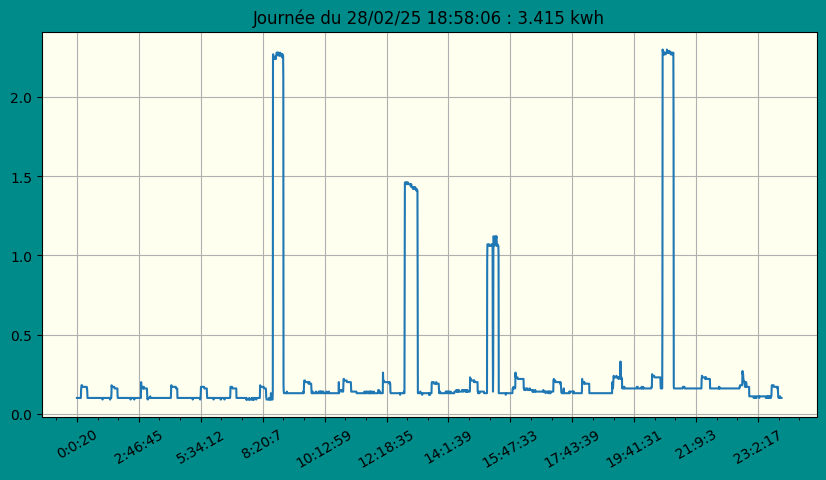

In [28]:
show('28/02/25')

### 1 kWh window in data of one day
#### df = conso_day

In [29]:
df = conso_day

In [30]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [31]:
df = conso_day
len(df)

2547

In [32]:
period()  # first kWh

2025-03-12 00:00:21.193460	2025-03-12 08:37:50.307460	8h 37m 29s 	1000


In [33]:
period(p=2) # second period

2025-03-12 08:37:50.307460	2025-03-12 13:48:13.077460	5h 10m 22s 	2000


In [34]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301631
dtype: float64

### mean for data grouped by days

In [35]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.52436
dtype: float64

In [36]:
last=df_grp.iloc[-1]['kWh']
last

2.547

In [37]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 2006338 to 2008884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2547 non-null   int64         
 1   kWh        2547 non-null   float64       
 2   sec        2547 non-null   float64       
 3   Wh         2547 non-null   float64       
 4   cumul(ms)  2547 non-null   int64         
 5   dates      2547 non-null   datetime64[ns]
 6   days       2547 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 159.2+ KB


# conso by date


In [38]:
# select day
day = today

#day = '16/08/24'
day

'12/03/25'

In [39]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
2006338,28845,0.12,28.845,124.804992,49084112408,2025-03-12 00:00:21.193460,12/03/25
2006339,28062,0.13,28.062,128.287364,49084140470,2025-03-12 00:00:49.255460,12/03/25
2006340,26454,0.14,26.454,136.085280,49084166924,2025-03-12 00:01:15.709460,12/03/25
2006341,26653,0.14,26.653,135.069223,49084193577,2025-03-12 00:01:42.362460,12/03/25
2006342,27661,0.13,27.661,130.147139,49084221238,2025-03-12 00:02:10.023460,12/03/25
...,...,...,...,...,...,...,...
2008880,20423,0.18,20.423,176.271850,49152262066,2025-03-12 18:56:10.851460,12/03/25
2008881,20441,0.18,20.441,176.116628,49152282507,2025-03-12 18:56:31.292460,12/03/25
2008882,19925,0.18,19.925,180.677541,49152302432,2025-03-12 18:56:51.217460,12/03/25
2008883,20782,0.17,20.782,173.226831,49152323214,2025-03-12 18:57:11.999460,12/03/25


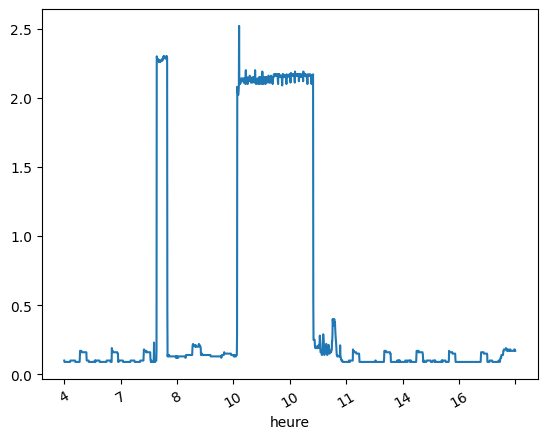

In [40]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


### grouped by 'heure'

In [41]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 2006338 to 2008884
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2547 non-null   int64         
 1   kWh        2547 non-null   float64       
 2   sec        2547 non-null   float64       
 3   Wh         2547 non-null   float64       
 4   cumul(ms)  2547 non-null   int64         
 5   dates      2547 non-null   datetime64[ns]
 6   days       2547 non-null   object        
 7   heure      2547 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 179.1+ KB


In [42]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,28845,0.12,28.845,124.804992,49084112408,2025-03-12 00:00:21.193460,12/03/25
0,28062,0.13,28.062,128.287364,49084140470,2025-03-12 00:00:49.255460,12/03/25
0,26454,0.14,26.454,136.085280,49084166924,2025-03-12 00:01:15.709460,12/03/25
0,26653,0.14,26.653,135.069223,49084193577,2025-03-12 00:01:42.362460,12/03/25
0,27661,0.13,27.661,130.147139,49084221238,2025-03-12 00:02:10.023460,12/03/25
...,...,...,...,...,...,...,...
18,20423,0.18,20.423,176.271850,49152262066,2025-03-12 18:56:10.851460,12/03/25
18,20441,0.18,20.441,176.116628,49152282507,2025-03-12 18:56:31.292460,12/03/25
18,19925,0.18,19.925,180.677541,49152302432,2025-03-12 18:56:51.217460,12/03/25


In [43]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [44]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     141
1     116
2     108
3      98
4     110
5     108
6     107
7      96
8     168
9     149
10    456
11    151
12    105
13    104
14     98
15    104
16    105
17    103
18    120
Name: kWh, dtype: int64

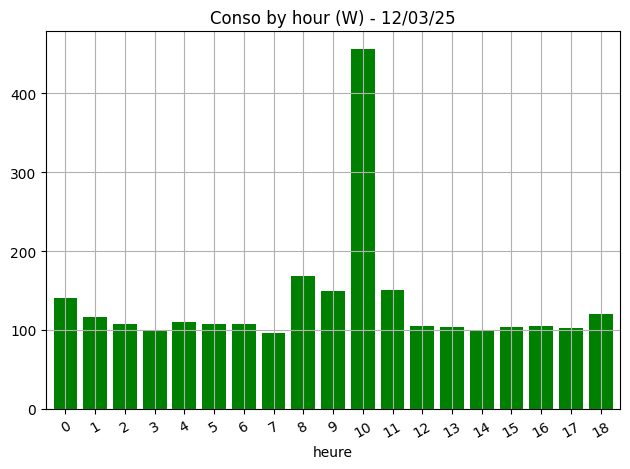

In [45]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [46]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 570 entries, 21/08/23 to 12/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     570 non-null    float64
dtypes: float64(1)
memory usage: 8.9+ KB


In [47]:
period()

2025-03-12 00:00:21.193460	2025-03-12 08:37:50.307460	8h 37m 29s 	1000


In [48]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time


heure
0     00:00:21.193460
0     00:00:49.255460
0     00:01:15.709460
0     00:01:42.362460
0     00:02:10.023460
           ...       
18    18:56:10.851460
18    18:56:31.292460
18    18:56:51.217460
18    18:57:11.999460
18    18:57:32.552460
Name: dates, Length: 2547, dtype: object

In [49]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
df_grp


,kWh
days,
21/08/23,0.520
22/08/23,3.691
23/08/23,4.242
24/08/23,3.687
25/08/23,3.920
...,...
08/03/25,3.425
09/03/25,4.399
10/03/25,3.730


In [50]:
df_grp.mean()


kWh    3.52436
dtype: float64

In [51]:
df_grp.head()


,kWh
days,
21/08/23,0.520
22/08/23,3.691
23/08/23,4.242
24/08/23,3.687
25/08/23,3.920


In [52]:
df_grp.tail()


,kWh
days,
08/03/25,3.425
09/03/25,4.399
10/03/25,3.730
11/03/25,3.307
12/03/25,2.547


# plot les 100 derniers jours


In [53]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.68286
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

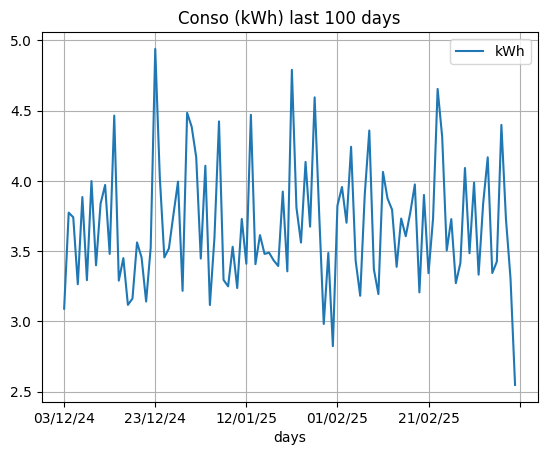

In [54]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [55]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.547
max,4.940


Text(0.5, 1.0, 'Last month conso by day')

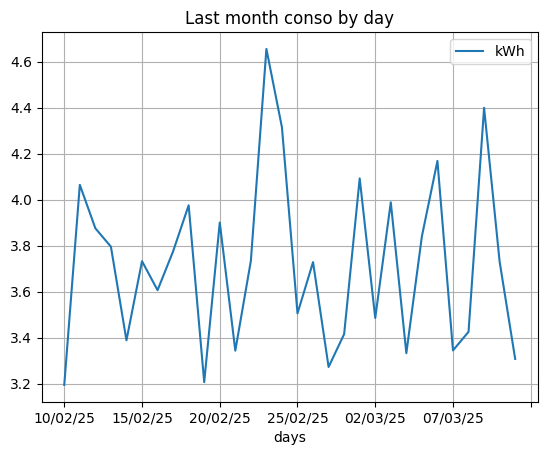

In [56]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [57]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.655
Min : 10/02/25 3.194


In [58]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-12 00:00:21.193460	2025-03-12 08:37:50.307460	8h 37m 29s 	1000
2025-03-12 08:37:50.307460	2025-03-12 13:48:13.077460	5h 10m 22s 	2000
2025-03-12 13:48:13.077460	2025-03-12 18:57:32.552460	5h 9m 19s 	547


('18:58:06', 2.547, 2547)

In [59]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 2006338 to 2008884
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2547 non-null   int64         
 1   kWh        2547 non-null   float64       
 2   sec        2547 non-null   float64       
 3   Wh         2547 non-null   float64       
 4   cumul(ms)  2547 non-null   int64         
 5   dates      2547 non-null   datetime64[ns]
 6   days       2547 non-null   object        
 7   heure      2547 non-null   object        
 8   hours      2547 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 199.0+ KB


In [60]:
conso_hours['heure'], conso_hours['hours']

(2006338     0
 2006339     0
 2006340     0
 2006341     0
 2006342     0
            ..
 2008880    18
 2008881    18
 2008882    18
 2008883    18
 2008884    18
 Name: heure, Length: 2547, dtype: object,
 2006338    00
 2006339    00
 2006340    00
 2006341    00
 2006342    00
            ..
 2008880    18
 2008881    18
 2008882    18
 2008883    18
 2008884    18
 Name: hours, Length: 2547, dtype: object)

In [61]:
# select number of days to display
span = 30
#df_grp.tail(span)


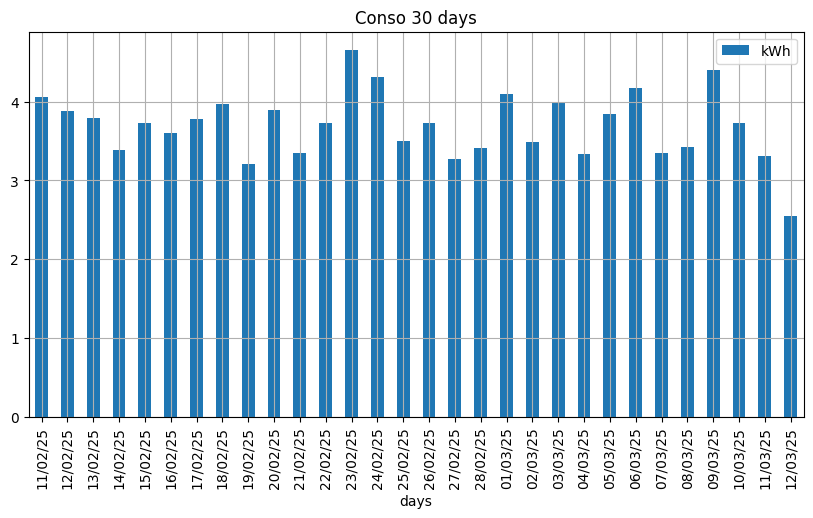

In [62]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


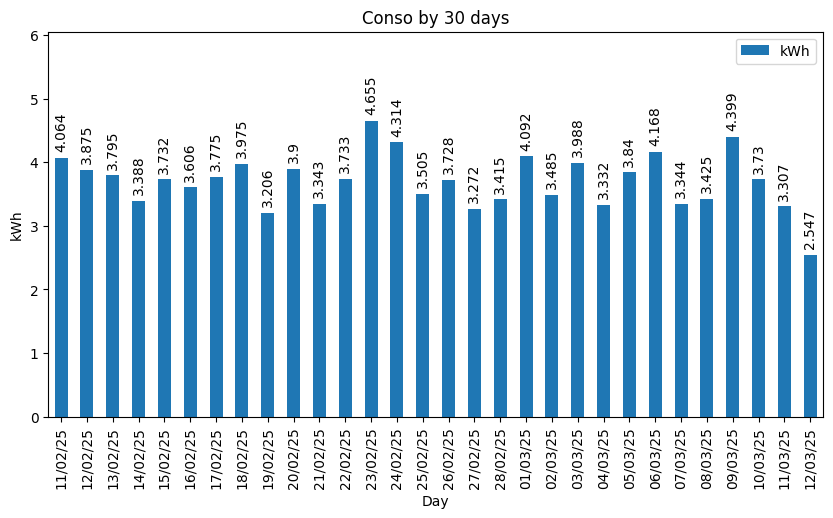

In [63]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [64]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
11/02/25    4.064
12/02/25    3.875
13/02/25    3.795
14/02/25    3.388
15/02/25    3.732
16/02/25    3.606
17/02/25    3.775
18/02/25    3.975
19/02/25    3.206
20/02/25    3.900
21/02/25    3.343
22/02/25    3.733
23/02/25    4.655
24/02/25    4.314
25/02/25    3.505
26/02/25    3.728
27/02/25    3.272
28/02/25    3.415
01/03/25    4.092
02/03/25    3.485
03/03/25    3.988
04/03/25    3.332
05/03/25    3.840
06/03/25    4.168
07/03/25    3.344
08/03/25    3.425
09/03/25    4.399
10/03/25    3.730
11/03/25    3.307
12/03/25    2.547
Name: kWh, dtype: float64

In [65]:
x_labels=df_grp.tail(span).index
x_labels

Index(['11/02/25', '12/02/25', '13/02/25', '14/02/25', '15/02/25', '16/02/25',
       '17/02/25', '18/02/25', '19/02/25', '20/02/25', '21/02/25', '22/02/25',
       '23/02/25', '24/02/25', '25/02/25', '26/02/25', '27/02/25', '28/02/25',
       '01/03/25', '02/03/25', '03/03/25', '04/03/25', '05/03/25', '06/03/25',
       '07/03/25', '08/03/25', '09/03/25', '10/03/25', '11/03/25', '12/03/25'],
      dtype='object', name='days')

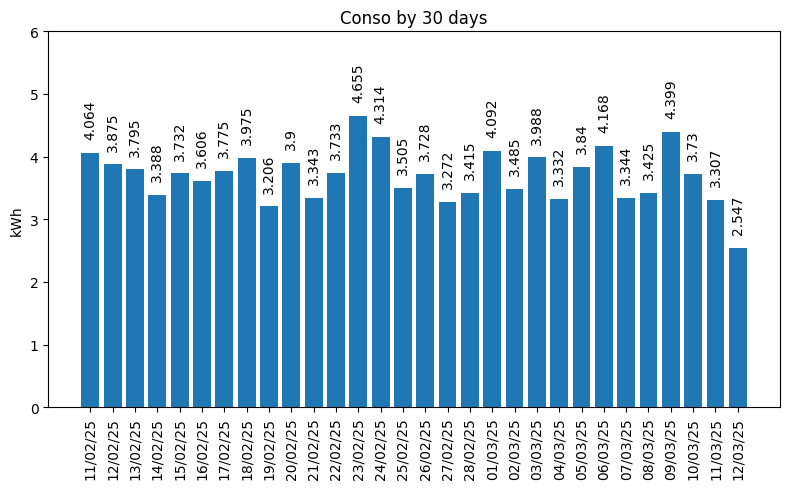

In [66]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [67]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

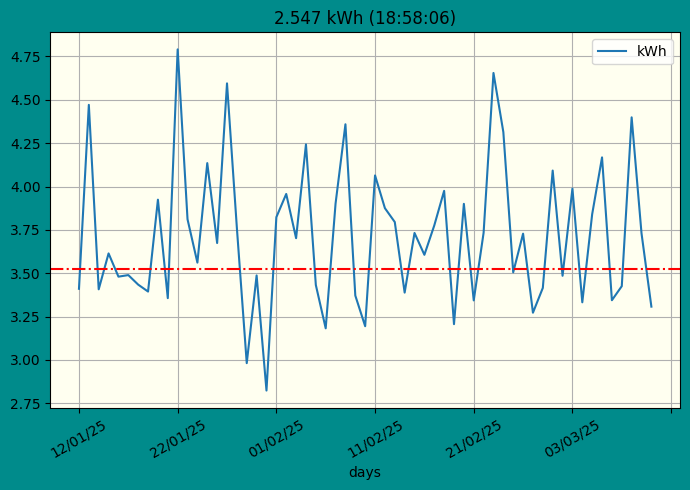

In [68]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

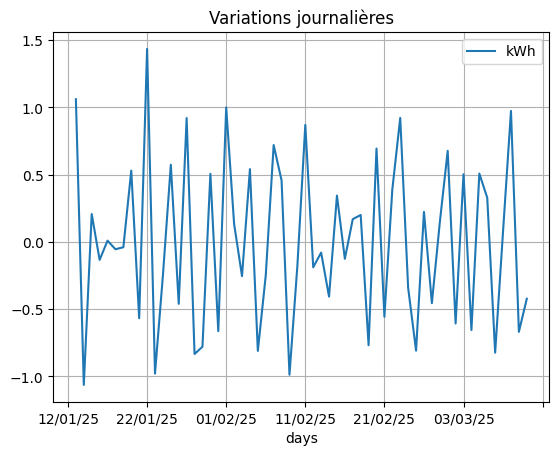

In [69]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

# Data from 21/08/23

In [70]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')


In [71]:
conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:32:10.719460,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:32:32.577460,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:32:54.578460,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:33:16.506460,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:33:38.397460,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2008880,20423,0.18,20.423,176.271850,49152262066,2025-03-12 18:56:10.851460,12/03/25,18,2025-03,12
2008881,20441,0.18,20.441,176.116628,49152282507,2025-03-12 18:56:31.292460,12/03/25,18,2025-03,12
2008882,19925,0.18,19.925,180.677541,49152302432,2025-03-12 18:56:51.217460,12/03/25,18,2025-03,12
2008883,20782,0.17,20.782,173.226831,49152323214,2025-03-12 18:57:11.999460,12/03/25,18,2025-03,12


In [72]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)


In [73]:
conso_grouped_by_month.groups.keys()

dict_keys(['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

In [74]:
month=conso_grouped_by_month.get_group('2024-11')

In [75]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

In [76]:
conso_grouped_by_month_day.count()


,hours,months,kWh
day,,,
01,3296,3296,3296
02,4139,4139,4139
03,3066,3066,3066
04,4070,4070,4070
05,3095,3095,3095
06,3411,3411,3411
07,3515,3515,3515
08,3960,3960,3960
09,3314,3314,3314


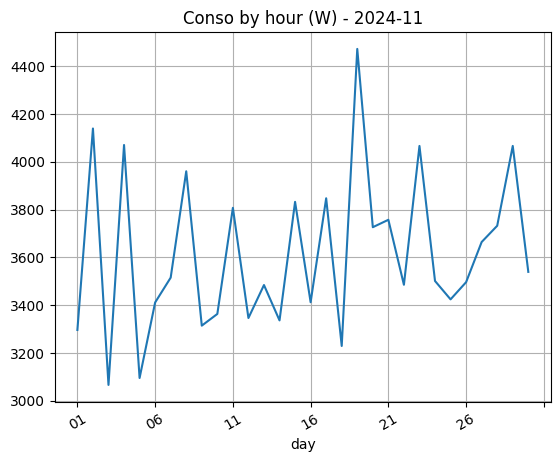

In [77]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [78]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [79]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3296,3296,3296
02,4139,4139,4139
03,3066,3066,3066
04,4070,4070,4070
05,3095,3095,3095
06,3411,3411,3411
07,3515,3515,3515
08,3960,3960,3960
09,3314,3314,3314


In [80]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [81]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [82]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2023-08,38438,38438,38438
2023-09,116315,116315,116315
2023-10,112868,112868,112868
2023-11,113602,113602,113602
2023-12,123307,123307,123307
2024-01,119515,119515,119515
2024-02,108753,108753,108753
2024-03,114277,114277,114277
2024-04,109926,109926,109926


In [83]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [84]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [85]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,520
22/08/23,3691
23/08/23,4242
24/08/23,3687
25/08/23,3920
...,...
08/03/25,3425
09/03/25,4399
10/03/25,3730


In [86]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:32:10.719460,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:32:32.577460,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:32:54.578460,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:33:16.506460,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:33:38.397460,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2008880,20423,0.18,20.423,176.271850,49152262066,2025-03-12 18:56:10.851460,12/03/25,18,2025-03,12
2008881,20441,0.18,20.441,176.116628,49152282507,2025-03-12 18:56:31.292460,12/03/25,18,2025-03,12
2008882,19925,0.18,19.925,180.677541,49152302432,2025-03-12 18:56:51.217460,12/03/25,18,2025-03,12
2008883,20782,0.17,20.782,173.226831,49152323214,2025-03-12 18:57:11.999460,12/03/25,18,2025-03,12


In [87]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
12/03/25 18    2008880  12/03/25    18  0.18
               2008881  12/03/25    18  0.18
               2008882  12/03/25    18  0.18
               2008883  12/03/25    18  0.17
               2008884  12/03/25    18  0.17

[2008885 rows x 3 columns]

In [88]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [89]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [90]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,520,520
22/08/23,3691,3691
23/08/23,4242,4242
24/08/23,3687,3687
25/08/23,3920,3920
...,...,...
08/03/25,3425,3425
09/03/25,4399,4399
10/03/25,3730,3730


In [91]:
grp_by_day['kWh'].cumsum()

days
21/08/23        520
22/08/23       4211
23/08/23       8453
24/08/23      12140
25/08/23      16060
             ...   
08/03/25    1994902
09/03/25    1999301
10/03/25    2003031
11/03/25    2006338
12/03/25    2008885
Name: kWh, Length: 570, dtype: int64

In [92]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21      83
         22     281
         23     156
22/08/23 00     132
         01     132
...             ...
12/03/25 14      98
         15     104
         16     105
         17     103
         18     120

[13654 rows x 1 columns]

In [93]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21            83
          22           364
          23           520
22/08/23  00           652
          01           784
                    ...   
12/03/25  14       2008453
          15       2008557
          16       2008662
          17       2008765
          18       2008885
Name: kWh, Length: 13654, dtype: int64

In [94]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21      83      83    NaN
         22     281     364  198.0
         23     156     520 -125.0
22/08/23 00     132     132    NaN
         01     132     264    0.0
...             ...     ...    ...
12/03/25 14      98    2115   -6.0
         15     104    2219    6.0
         16     105    2324    1.0
         17     103    2427   -2.0
         18     120    2547   17.0

[13654 rows x 3 columns]

In [95]:
today, grp_by_dayhours.loc[today]

('12/03/25',
        kWh  cumsum   diff
 hours                    
 00     141     141    NaN
 01     116     257  -25.0
 02     108     365   -8.0
 03      98     463  -10.0
 04     110     573   12.0
 05     108     681   -2.0
 06     107     788   -1.0
 07      96     884  -11.0
 08     168    1052   72.0
 09     149    1201  -19.0
 10     456    1657  307.0
 11     151    1808 -305.0
 12     105    1913  -46.0
 13     104    2017   -1.0
 14      98    2115   -6.0
 15     104    2219    6.0
 16     105    2324    1.0
 17     103    2427   -2.0
 18     120    2547   17.0)

Text(0.5, 1.0, 'Cumul journalier')

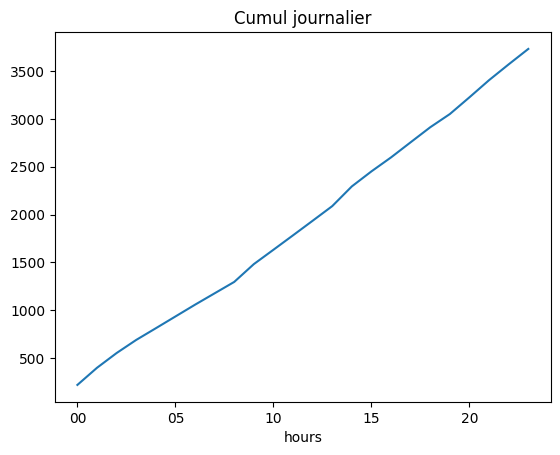

In [96]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

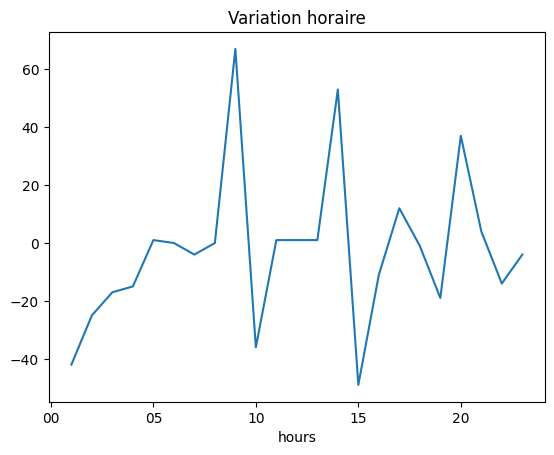

In [97]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [98]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

570

In [99]:
df_grp.tail(n)['kWh'].describe()


count    570.000000
mean       3.524360
std        0.662129
min        0.520000
25%        3.347250
50%        3.626500
75%        3.893000
max        4.975000
Name: kWh, dtype: float64

In [100]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '570 days')

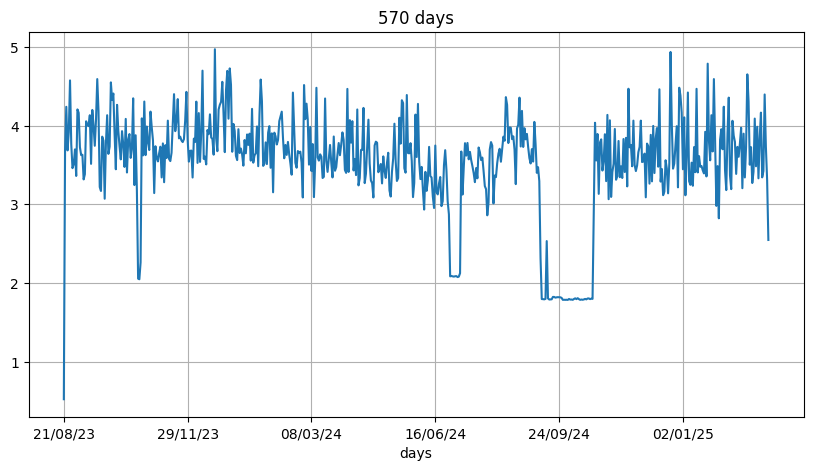

In [101]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

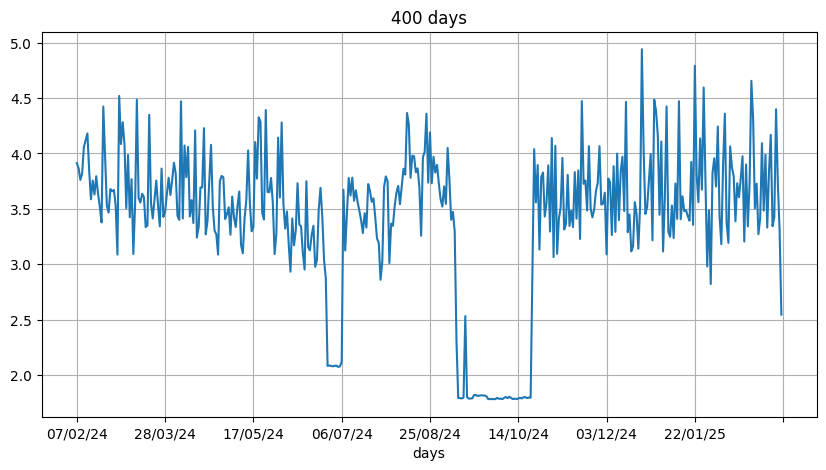

In [102]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [103]:
df_grp['kWh']

days
21/08/23    0.520
22/08/23    3.691
23/08/23    4.242
24/08/23    3.687
25/08/23    3.920
            ...  
08/03/25    3.425
09/03/25    4.399
10/03/25    3.730
11/03/25    3.307
12/03/25    2.547
Name: kWh, Length: 570, dtype: float64

In [104]:
df_grp.describe()

,kWh
count,570.000000
mean,3.524360
std,0.662129
min,0.520000
25%,3.347250
50%,3.626500
75%,3.893000
max,4.975000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

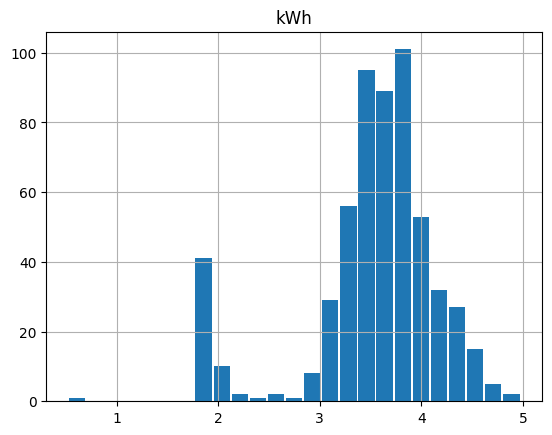

In [105]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [106]:
df_grp.tail(span)['kWh']

days
07/02/24    3.913
08/02/24    3.867
09/02/24    3.762
10/02/24    3.820
11/02/24    4.059
            ...  
08/03/25    3.425
09/03/25    4.399
10/03/25    3.730
11/03/25    3.307
12/03/25    2.547
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [107]:
day

'12/03/25'

In [108]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,141,141,NaN
01,116,257,-25.0
02,108,365,-8.0
03,98,463,-10.0
04,110,573,12.0
05,108,681,-2.0
06,107,788,-1.0
07,96,884,-11.0
08,168,1052,72.0


In [109]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


19

In [110]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 20)

In [111]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [112]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19.])

In [113]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
Name: days, dtype: float64

In [114]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [115]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 00 to 18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     19 non-null     int64  
 1   cumsum  19 non-null     int64  
 2   diff    18 non-null     float64
 3   days    19 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 760.0+ bytes


In [116]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
Name: days, dtype: float64

In [117]:
day

'12/03/25'

In [118]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,141,141,NaN,1.0
01,116,257,-25.0,2.0
02,108,365,-8.0,3.0
03,98,463,-10.0,4.0
04,110,573,12.0,5.0
05,108,681,-2.0,6.0
06,107,788,-1.0,7.0
07,96,884,-11.0,8.0
08,168,1052,72.0,9.0


Text(0.5, 1.0, '12/03/25')

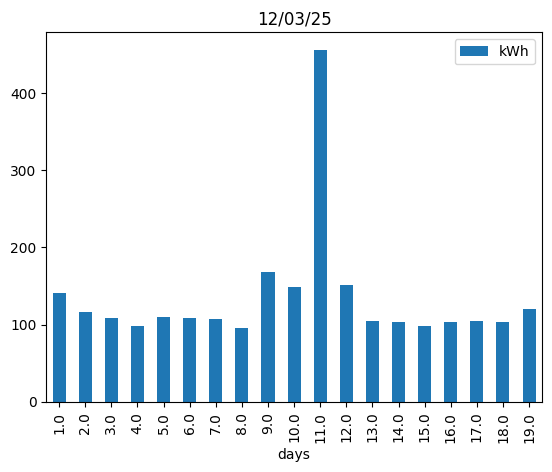

In [119]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [120]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18'],
      dtype='object', name='hours')

# Conso du jour


In [121]:

grp_by_dayhours.count()

kWh       13654
cumsum    13654
diff      13084
days         19
dtype: int64

In [122]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    152
01    165
02    158
03    160
04    168
05    151
06    165
07    150
08    115
09    130
10    114
11    131
12    130
13    115
14    130
15    191
16    148
17    154
18    951
19    196
20    286
21    306
22    306
23    303
Name: kWh, dtype: int64

In [123]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
12/03/25  2.547


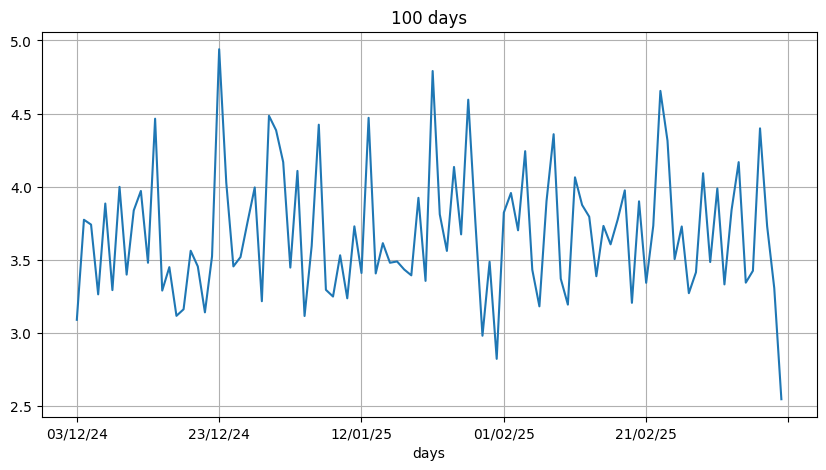

In [124]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [125]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

155.06792736053467


# Today

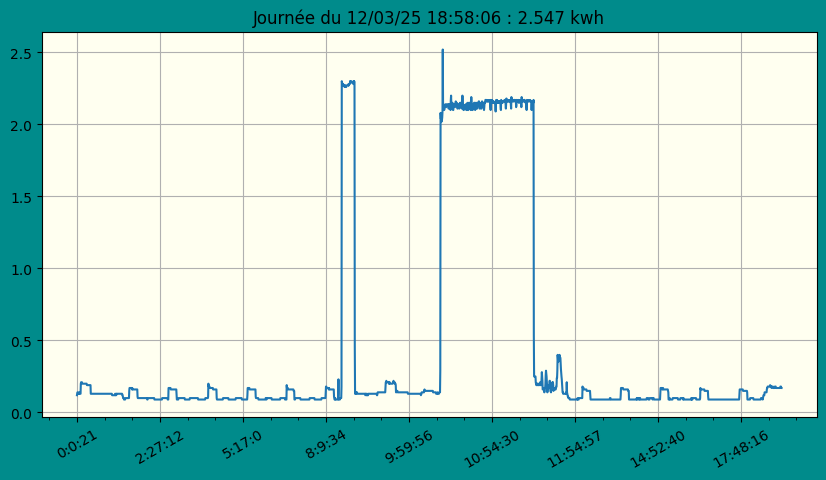

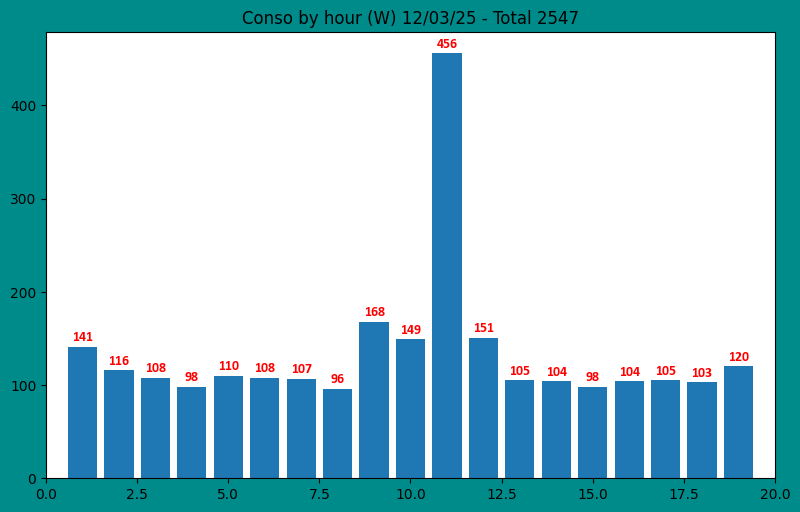

In [126]:
show(today,bgcolor='ivory')
conso_by_hour(today)

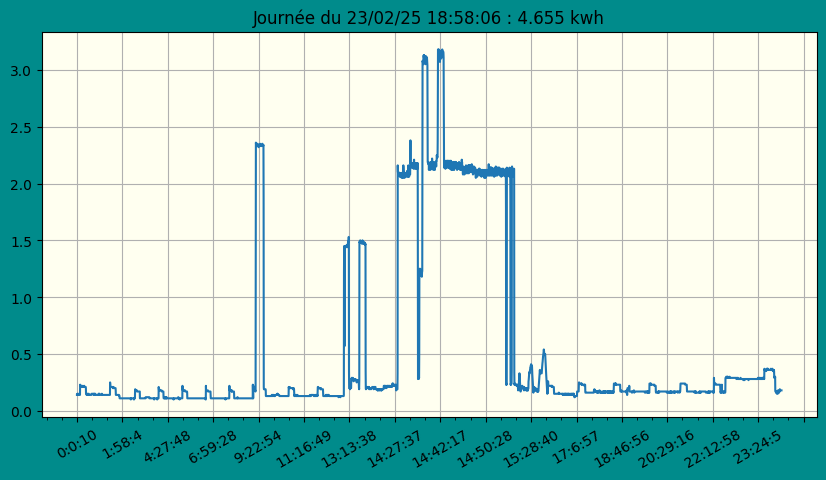

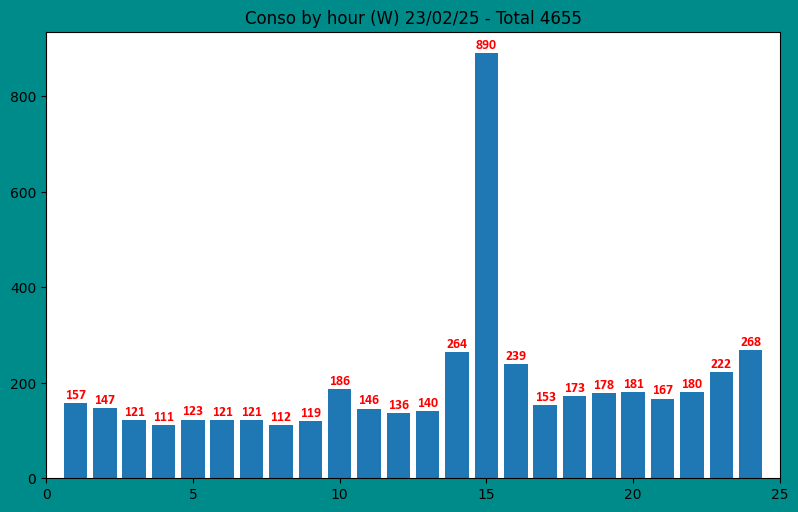

In [127]:
day = '23/02/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

21/12/23


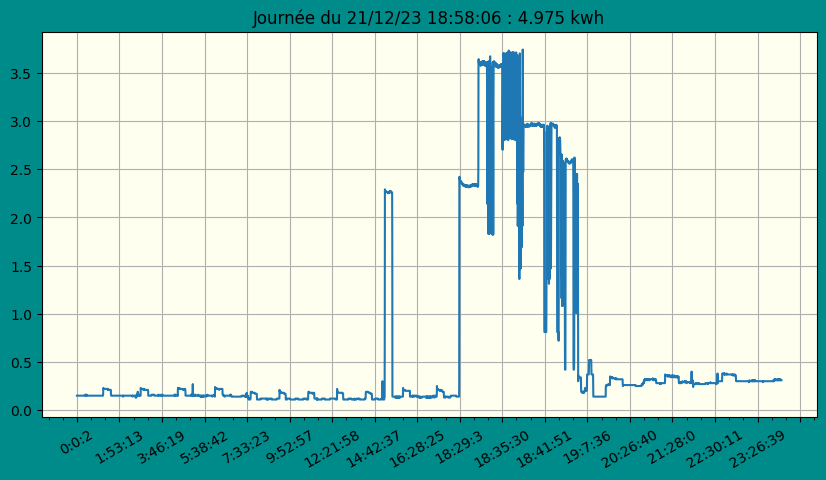

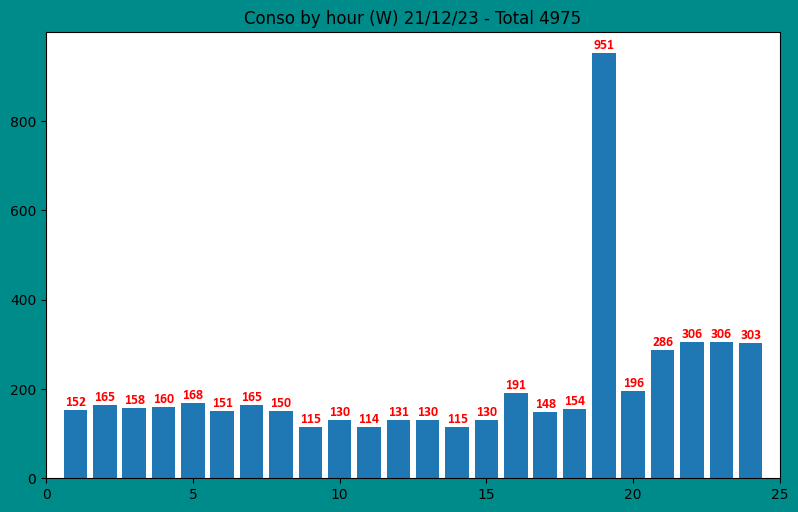

In [128]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day)

In [129]:
sum(data)

4975

In [130]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,141,141,NaN,1.0
01,116,257,-25.0,2.0
02,108,365,-8.0,3.0
03,98,463,-10.0,4.0
04,110,573,12.0,5.0
05,108,681,-2.0,6.0
06,107,788,-1.0,7.0
07,96,884,-11.0,8.0
08,168,1052,72.0,9.0


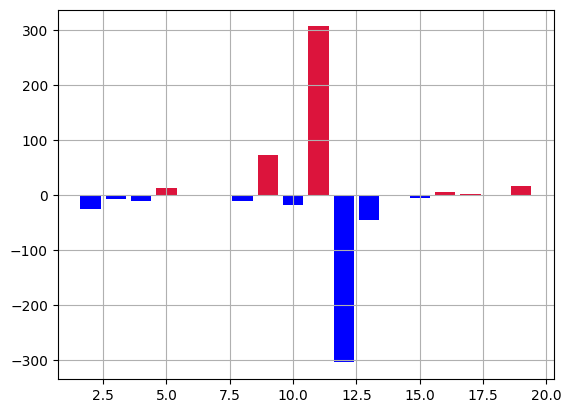

In [131]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [132]:
data

hours
00    152
01    165
02    158
03    160
04    168
05    151
06    165
07    150
08    115
09    130
10    114
11    131
12    130
13    115
14    130
15    191
16    148
17    154
18    951
19    196
20    286
21    306
22    306
23    303
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

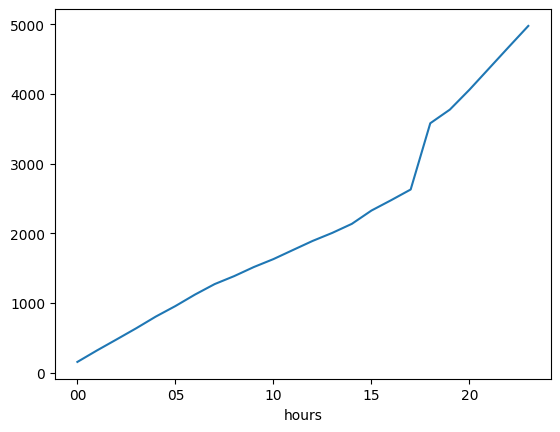

In [133]:
data.cumsum().plot()


<Axes: xlabel='hours'>

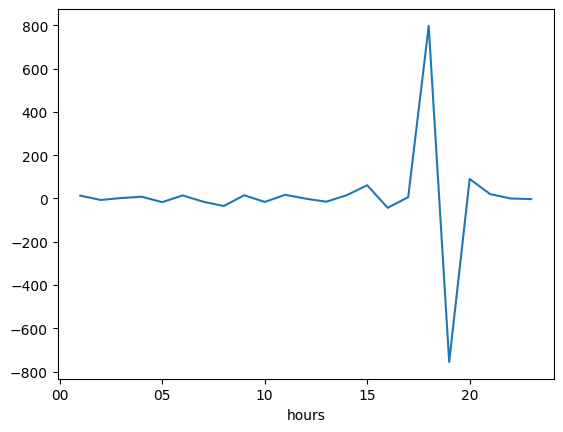

In [134]:
# evolution par heure
data.diff().plot()

In [135]:
data.diff().describe()

count     23.000000
mean       6.565217
std      235.661511
min     -755.000000
25%      -15.000000
50%        2.000000
75%       15.000000
max      797.000000
Name: kWh, dtype: float64

<Axes: >

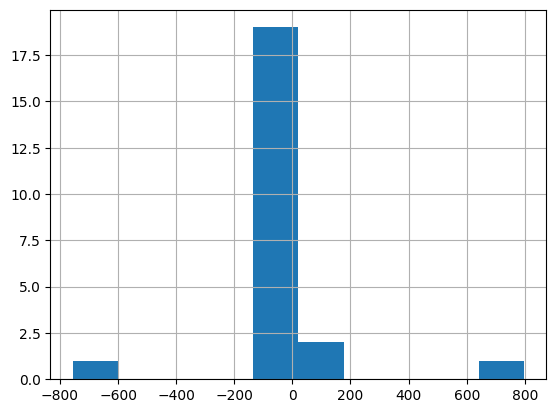

In [136]:
data.diff().hist()

# Test sauvegarde

In [137]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [138]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [139]:
#conso_byhour(day)

In [140]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


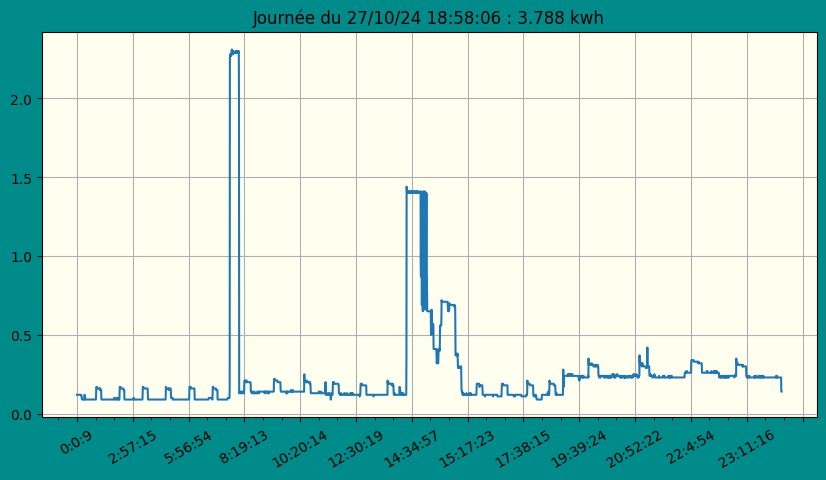

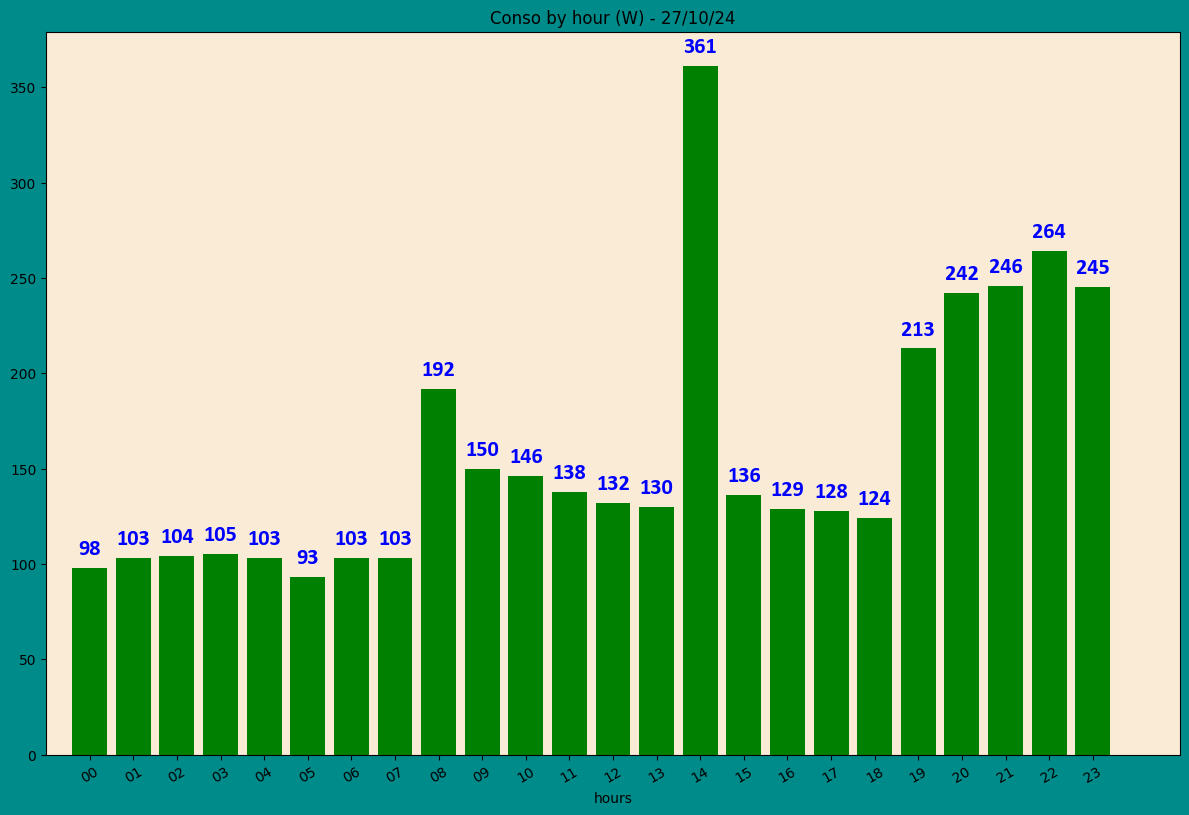

In [141]:
day = '27/10/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [142]:
month.describe()


,kWh
count,108450.000000
mean,0.334557
std,0.564572
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.730000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

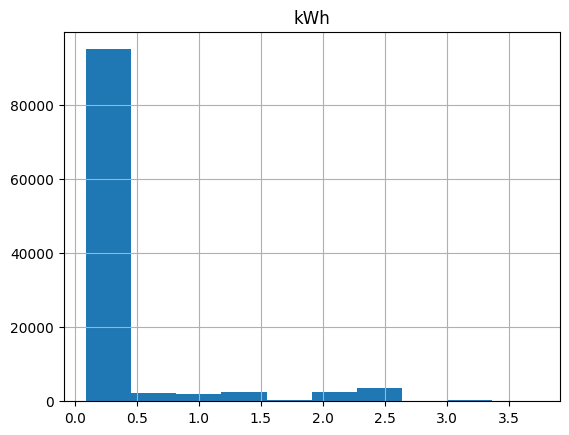

In [143]:
month.hist()

<Axes: >

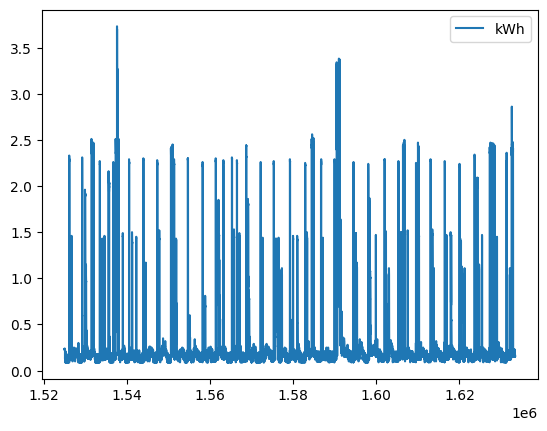

In [144]:
month.plot()

In [145]:
# index with max conso in this month
month.idxmax().kWh

1537642

In [146]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

day       1629867
hours     1528082
months    1524956
kWh       1537642
dtype: int64

In [147]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [148]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21      83      83    NaN   NaN
         22     281     364  198.0   NaN
         23     156     520 -125.0   NaN
22/08/23 00     132     132    NaN   NaN
         01     132     264    0.0   NaN
...             ...     ...    ...   ...
12/03/25 14      98    2115   -6.0  15.0
         15     104    2219    6.0  16.0
         16     105    2324    1.0  17.0
         17     103    2427   -2.0  18.0
         18     120    2547   17.0  19.0

[13654 rows x 4 columns]

In [149]:
month

,day,hours,months,kWh
1524956,01,00,2024-11,0.23
1524957,01,00,2024-11,0.23
1524958,01,00,2024-11,0.23
1524959,01,00,2024-11,0.23
1524960,01,00,2024-11,0.23
...,...,...,...,...
1633401,30,23,2024-11,0.15
1633402,30,23,2024-11,0.15
1633403,30,23,2024-11,0.15
1633404,30,23,2024-11,0.15


In [150]:
month.idxmax()


day       1629867
hours     1528082
months    1524956
kWh       1537642
dtype: int64

In [151]:
month.loc[month.idxmax().kWh]


day            04
hours          13
months    2024-11
kWh          3.73
Name: 1537642, dtype: object

In [152]:
grp_by_dayhours.loc[['28/02/25']].idxmax()

C:\Users\jean\AppData\Local\Temp\ipykernel_9824\4095454801.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  grp_by_dayhours.loc[['28/02/25']].idxmax()


kWh       (28/02/25, 20)
cumsum    (28/02/25, 23)
diff      (28/02/25, 12)
days                 NaN
dtype: object

In [153]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [154]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [155]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [156]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB